# Assignment 2 of Homework 11 for PUI 2016
# CLUSTERING BUSINESS
## cluster time trends in NYC businesses
Thursday Session

** Name:** Cheng Hou

** NetID:** ch3019

---

In [101]:
from __future__ import print_function
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import matplotlib.patches as mpatches
import os
import shlex
import subprocess as sp
import geopandas as gpd
from fiona.crs import from_epsg
import shapely
import zipfile
from sklearn import cluster
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

%matplotlib inline

if os.getenv("PUIDATA") is None:
    print ("error: $PUIDATA env variable does not exist!")
else:
    puidata = os.getenv("PUIDATA")
    if not os.path.exists(puidata):
        os.system("mkdir " + puidata)
    print ("$PUIDATA: {}".format(puidata))

$PUIDATA: /home/cusp/ch3019/PUIdata


---
## 1. Download Data
### Download census data for businesses by ZIP code from [US Census FTP server](ftp://ftp.census.gov/)
The homework instruction asks for data from 1993 to 2015. But data of **1993** and **2015** is actually **not available**.

In [2]:
Years = range(1994,2015)

To avoid my *\$PUIDATA* directory become a mess, I move all the zip file to the directory called ** *CBP_CSV* ** that just under my *\$PUIDATA* directory.

In [3]:
# fdir = puidata
fdir = puidata + '/CBP_CSV'

**Warning:** the downloading procedure may take a long time!

The zip files are called **zbp\*\*.zip** (\*\* represent the last 2 digits of the years).

The data from 2001 and earlier is in the path **[ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/](ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/)**

The data later than 2001 is in the path **ftp://ftp.census.gov/econ\*\*/CBP_CSV/** (\*\* represent the last 2 digits of the years).

In [4]:
def getCensusBusiness(Years, fdir, overview=False):
    # Check the path exists
    if not os.path.exists(fdir):
        os.system("mkdir " + fdir)
    
    filenames = []
    for year in Years:        
        # get url and name corresponding to the yaer.
        name = 'zbp{}totals.zip'.format(str(year)[-2:])
        if year <= 2001:
            url = 'ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/{}'.format(name)
        else:
            url = 'ftp://ftp.census.gov/econ{}/CBP_CSV/{}'.format(year, name)
        
        # use wget to download data
        if not os.path.isfile(fdir + '/' + name):
            if not os.path.isfile(name):
                !wget $url$name 
            if os.path.isfile(name):
                os.system("mv " + name + " " + fdir)
        
        if os.path.isfile(fdir + '/' + name):
            filenames.append(name)
    
    print (" The data move to \n  {}".format(fdir))
    
    #overview
    if overview:
        cmd = 'cd {}; ls'.format(fdir)
        p = sp.Popen(cmd, shell=True, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT, close_fds=True)
        print (p.stdout.read())
    
    # Add to getCensusBusiness Attributes
    getCensusBusiness.fdir = fdir
    getCensusBusiness.filenames = filenames
    print("Complete!")
    return 0

In [5]:
getCensusBusiness(Years, fdir)
CBfilenames = getCensusBusiness.filenames

 The data move to 
  /home/cusp/ch3019/PUIdata/CBP_CSV
Complete!


### Download NYC zip codes shape file from [fedhere's github repo](https://github.com/fedhere/PUI2016_fb55/blob/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson)

In [6]:
def getNYCzipcode(filename='nyc-zip-code-tabulation-areas-polygons.geojson',
                  url='https://raw.githubusercontent.com/fedhere/PUI2016_fb55/\
                  master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson'):
    if not os.path.isfile(puidata + '/' + filename):
        if not os.path.isfile(filename):
            if os.system("wget " + url) != 0:
                print ("error: Cannot download file : {}".format(filename))
                return 1
        print ("Moves geojson file to {}".format(puidata))
        os.system("mv " + filename + " " + puidata)
    
    # Add to getNYCzipcode Attributes
    getNYCzipcode.filename = puidata + '/' + filename
    getNYCzipcode.url = url    
    print ("Complete.")
    return 0

In [7]:
getNYCzipcode()
ZCfilename = getNYCzipcode.filename

Complete.


## 2. Read and Merge Data

In [8]:
zipNYC = gpd.read_file(ZCfilename)
zipNYC.rename(columns={'postalCode': "zipcode"}, inplace=True)
zipNYC = zipNYC.loc[:, ['zipcode', 'geometry', 'borough', 'PO_NAME']]
zipNYC.zipcode = pd.to_numeric(zipNYC.zipcode)
zipNYC.head(2)

,zipcode,geometry,borough,PO_NAME
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks


In [9]:
mydata = zipNYC.copy()
for name in CBfilenames:
    zf = zipfile.ZipFile(fdir + '/' + name)
    df = pd.read_csv(zf.open(name.replace('.zip','.txt')))
    df.columns = map(str.lower, df.columns)
    
    CB = df[np.in1d(df.zip, zipNYC.zipcode)].loc[:,['zip','est']]   
    CB.rename(columns={'zip': 'zipcode', 'est': 'est{}'.format(name[3:5])}, inplace=True)
    CB.zipcode = pd.to_numeric(CB.zipcode)
    mydata = pd.merge(mydata, CB, on='zipcode')

In [10]:
mydata.head(2)

,zipcode,geometry,borough,PO_NAME,est94,est95,est96,est97,est98,est99,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights,1229,1236,1292,1309,1351,1376,...,1539,1527,1545,1538,1572,1629,1647,1724,1759,1768
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks,194,188,176,192,194,186,...,225,226,238,227,233,229,222,241,241,250


## 3. Whiten the data

In [11]:
my_mean = mydata.iloc[:,range(4,25)].mean(axis=1)
my_std = mydata.iloc[:,range(4,25)].std(axis=1)
mydata.iloc[:,range(4,25)] = mydata.iloc[:,range(4,25)].apply(lambda x: (x-my_mean) / my_std)
mydata.head(2)

,zipcode,geometry,borough,PO_NAME,est94,est95,est96,est97,est98,est99,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923


## 4. KMeans Clustering
### Choose the number of clusters.
Select the **NUMBER OF ESTABLISHMENTS time series** as X.

Choose the number of clusters in $[2,3,4,5,6,7,8,9]$

In [12]:
X = mydata.iloc[:,4:]
range_n_clusters = range(2,10)

Use **Silhouette Score**

In [13]:
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=123)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(n_clusters, silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.572142801777
For n_clusters = 3, the average silhouette_score is : 0.541072613328
For n_clusters = 4, the average silhouette_score is : 0.497960563894
For n_clusters = 5, the average silhouette_score is : 0.256258041159
For n_clusters = 6, the average silhouette_score is : 0.246473153897
For n_clusters = 7, the average silhouette_score is : 0.322595040221
For n_clusters = 8, the average silhouette_score is : 0.166052596244
For n_clusters = 9, the average silhouette_score is : 0.190617863179


I choose **4** as the number of clusters.
### Do KMeans and plot

In [14]:
n_clusters = 4
KM = cluster.KMeans(n_clusters=n_clusters, n_init=12, random_state=123)
KM.fit(X)
centers = KM.cluster_centers_
labels = KM.labels_

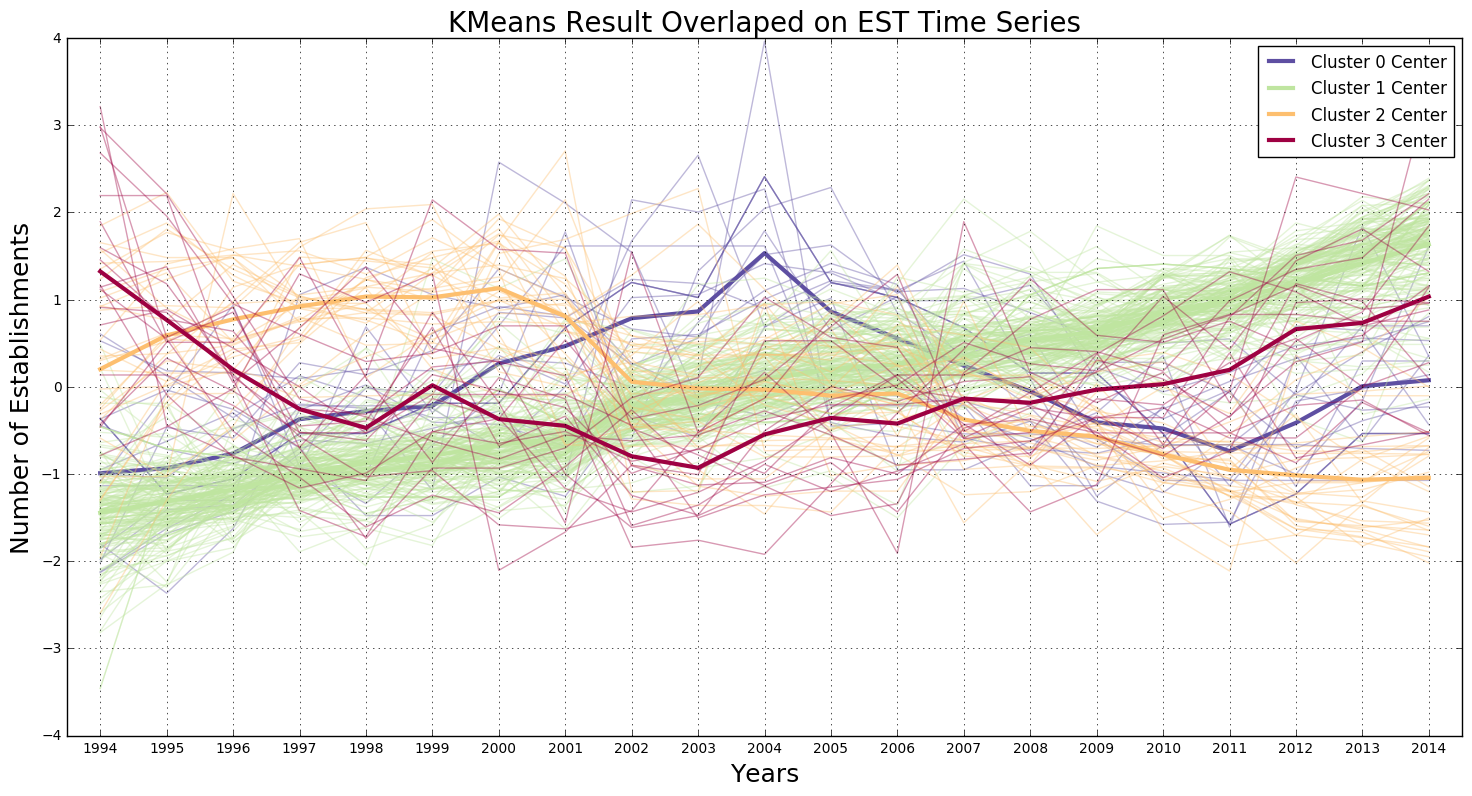

In [54]:
cmap = plt.cm.Spectral_r(np.linspace(0,1,n_clusters))
plt.figure(figsize=(18,9))
for i in range(n_clusters):
    Xp = X[labels == i]
    for j in range(len(Xp)):
        plt.plot(Years, Xp.iloc[j], lw=1, c=cmap[i], alpha=0.4, label='_nolegend_')
    plt.plot(Years, centers[i], lw=3, c=cmap[i], label='Cluster %d Center'%i)
    
plt.xlim(1993.5,2014.5)
plt.xticks(Years)
plt.grid(True)
plt.legend()
plt.xlabel('Years', fontsize=18)
plt.ylabel('Number of Establishments', fontsize=18)
plt.title('KMeans Result Overlaped on EST Time Series', fontsize=20)
plt.show()

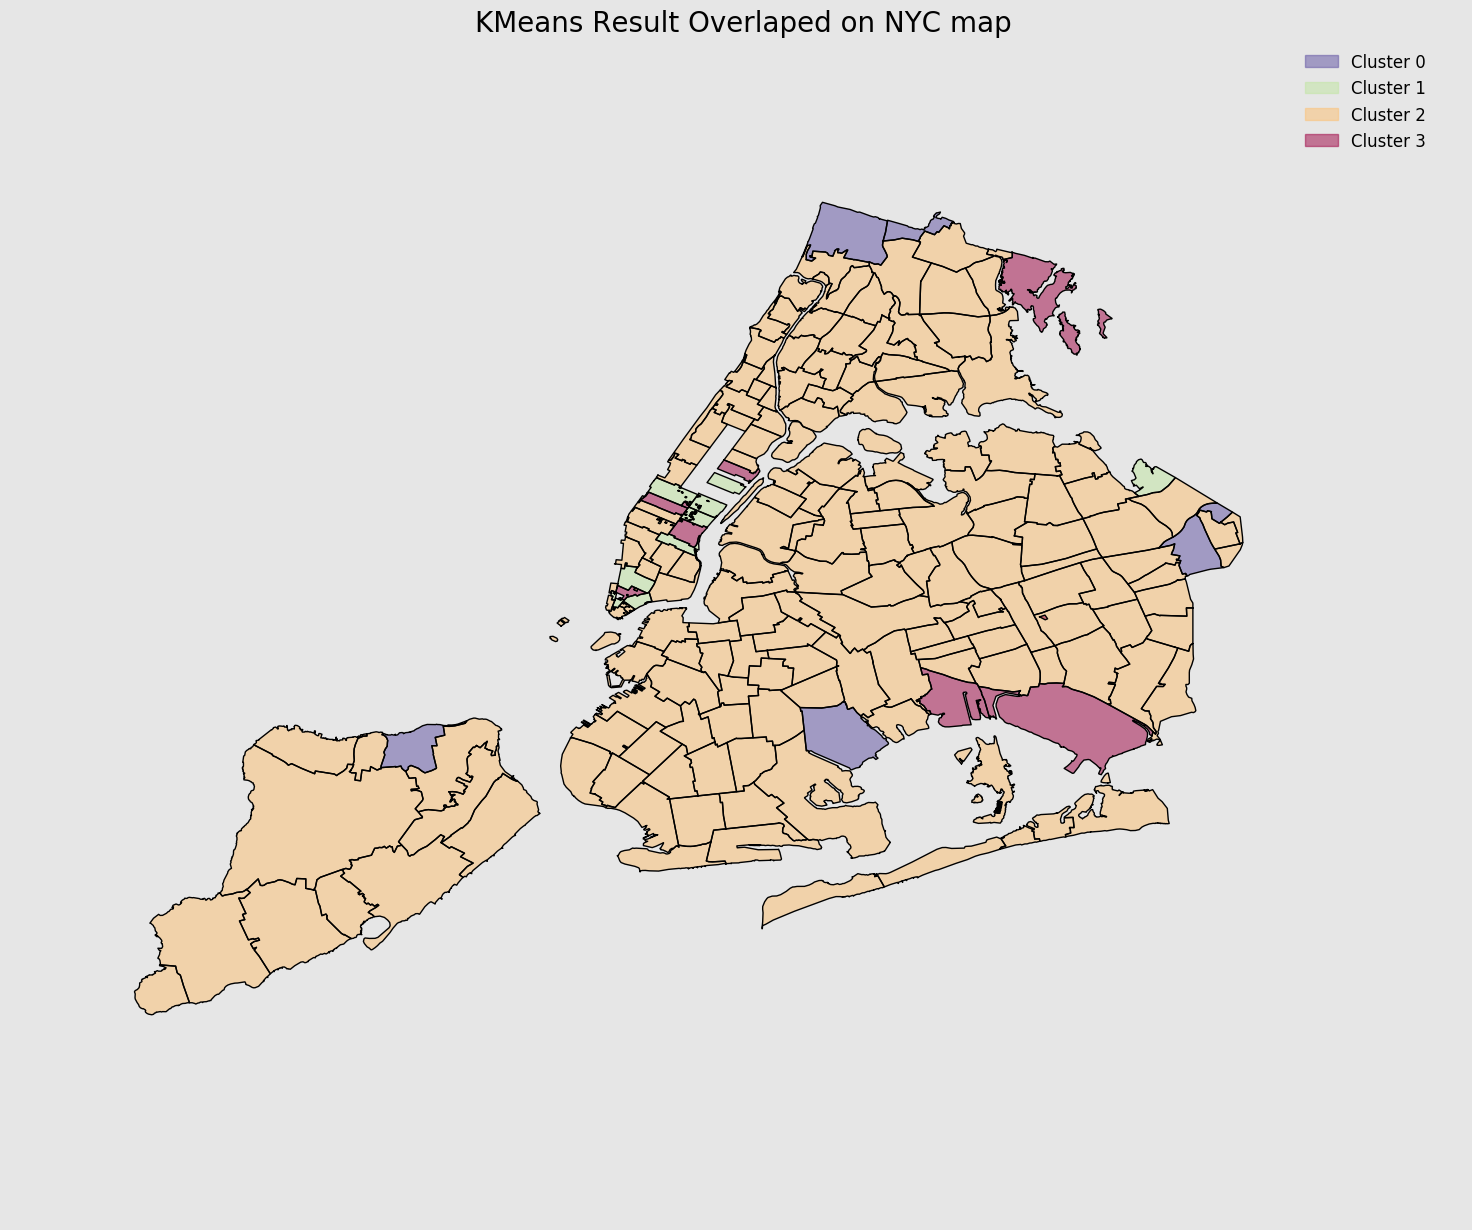

In [92]:
KMplot = gpd.GeoDataFrame(pd.concat([mydata.geometry, pd.DataFrame(labels, columns=['label'])], axis=1))

fig, ax = plt.subplots(figsize=(18,15))
KMplot.plot(ax=ax, column='label', cmap=plt.cm.Spectral, label='_nolegend_')
fig.set_facecolor('0.9')
ax.set_title('KMeans Result Overlaped on NYC map', fontsize=20)
patch = [mpatches.Patch(color=cmap[i], alpha=0.5, label='Cluster %i'%i) for i in range(4)]
ax.legend(handles=patch, frameon=False)
ax.set_axis_off()

## 5. Hierarchical Clustering

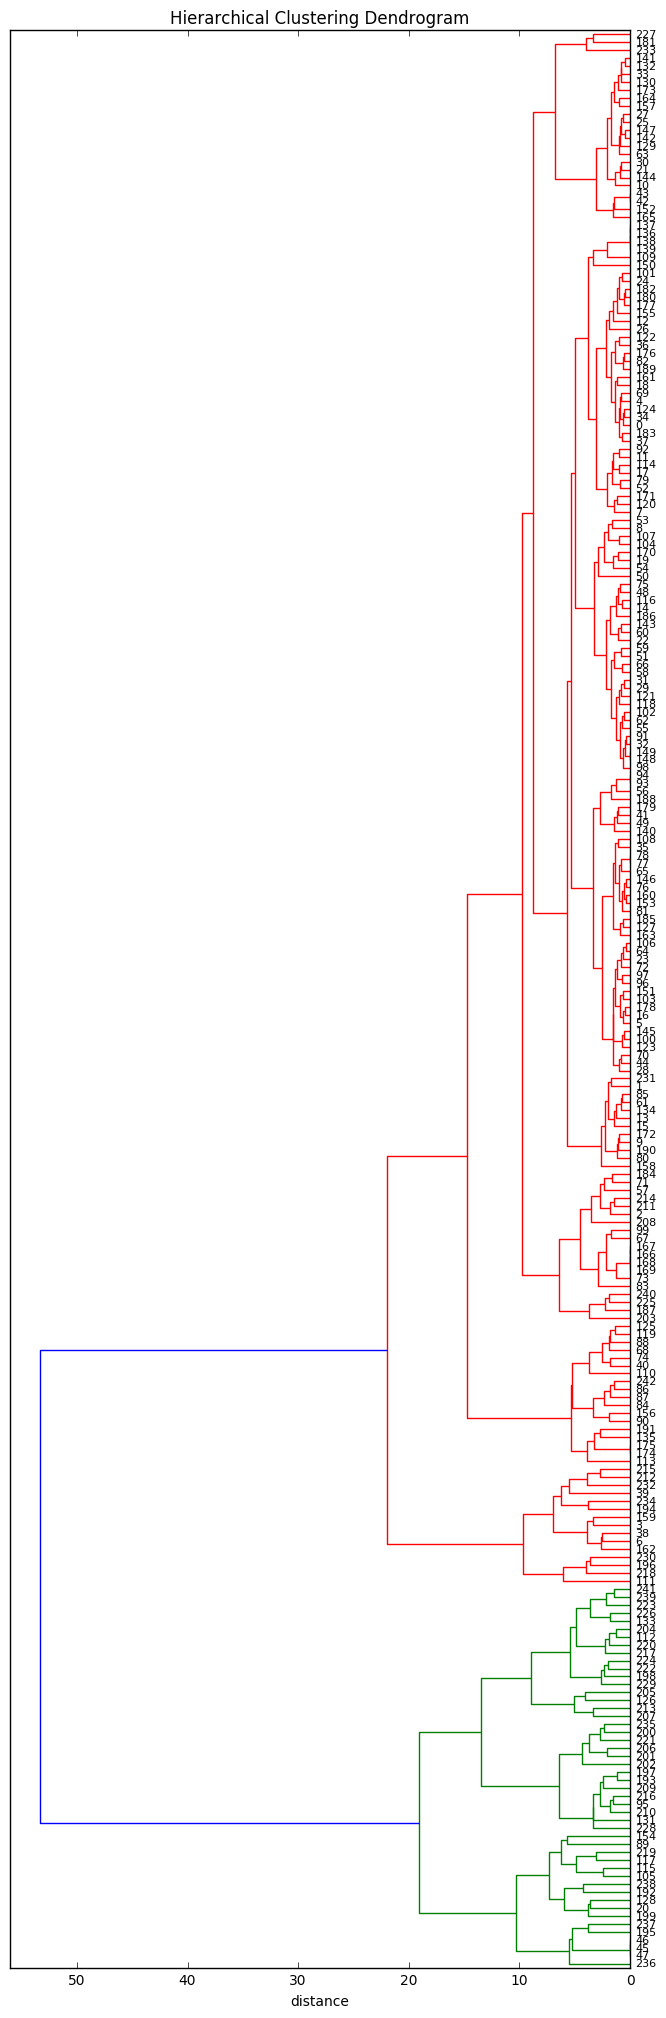

In [100]:
Z = sch.linkage(X, 'ward')
plt.figure(figsize=(8, 25))
plt.title('Hierarchical Clustering Dendrogram')
sch.dendrogram(Z, orientation='left', leaf_font_size=8)
plt.xlabel('distance')
plt.show()

In [102]:
labels2 = sch.fcluster(Z, 4, criterion='maxclust')

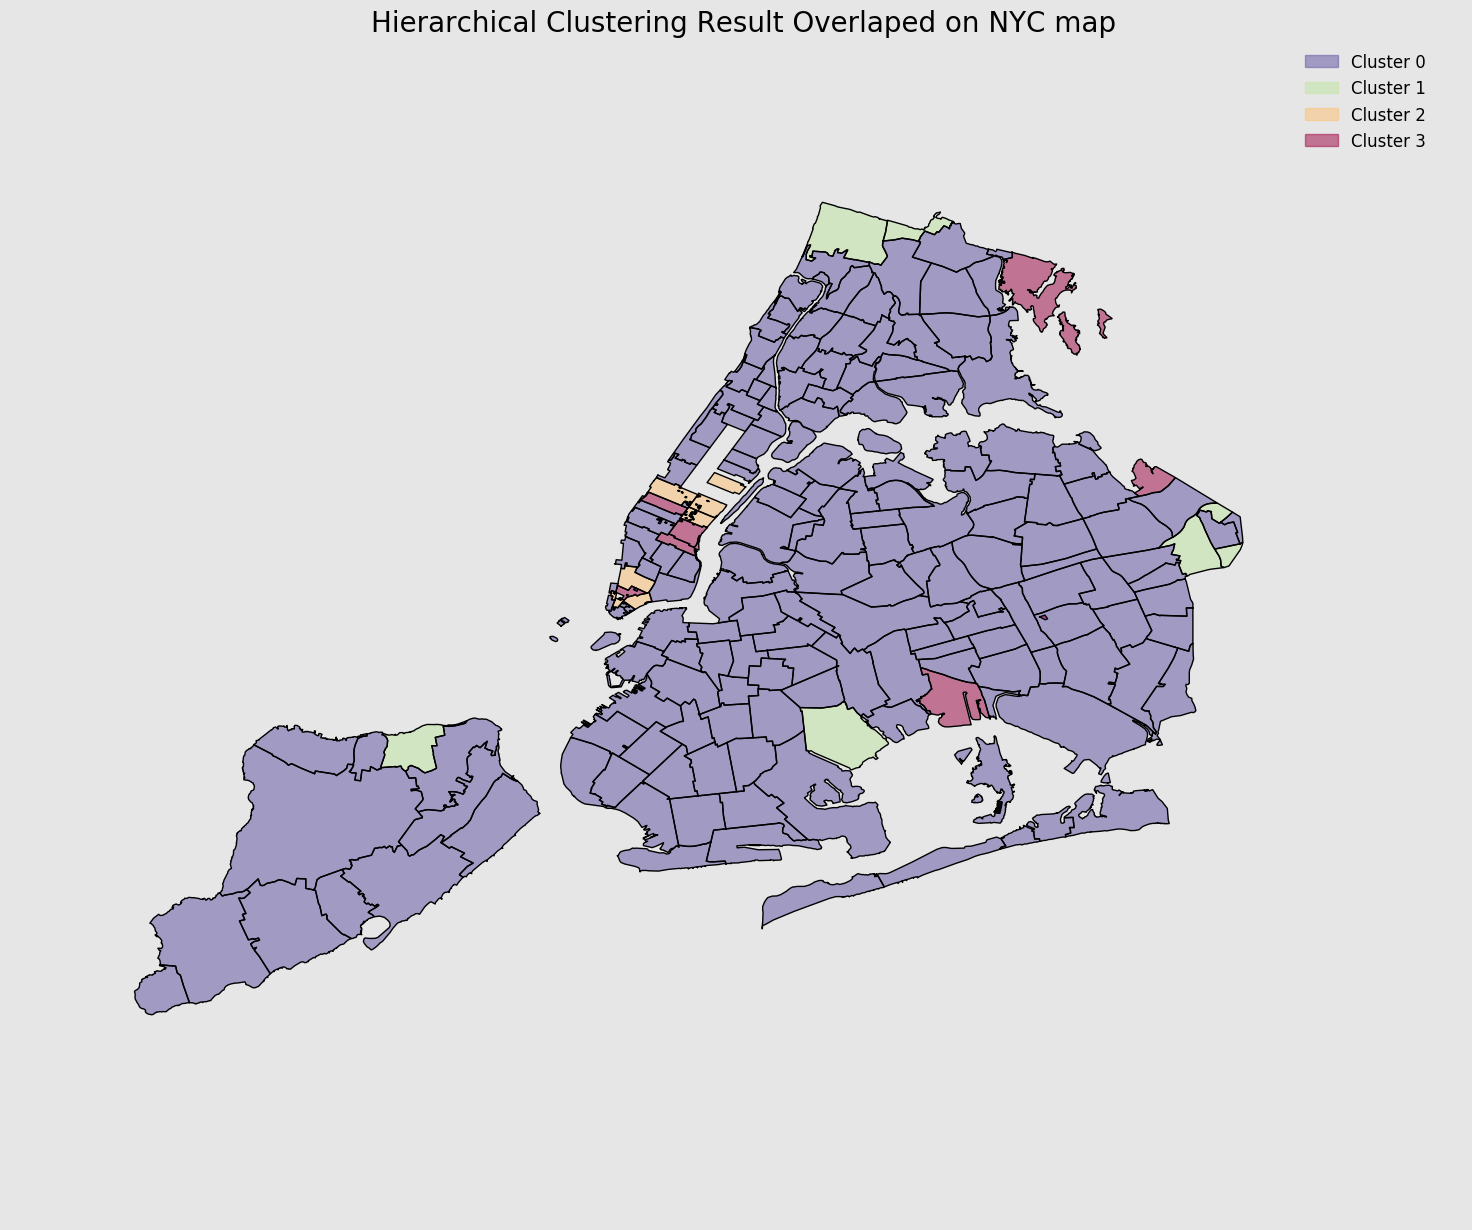

In [106]:
HCplot = gpd.GeoDataFrame(pd.concat([mydata.geometry, pd.DataFrame(labels2, columns=['label'])], axis=1))

fig, ax = plt.subplots(figsize=(18,15))
HCplot.plot(ax=ax, column='label', cmap=plt.cm.Spectral, label='_nolegend_')
fig.set_facecolor('0.9')
ax.set_title('Hierarchical Clustering Result Overlaped on NYC map', fontsize=20)
patch = [mpatches.Patch(color=cmap[i], alpha=0.5, label='Cluster %i'%i) for i in range(4)]
ax.legend(handles=patch, frameon=False)
ax.set_axis_off()

## 6. Compare the results

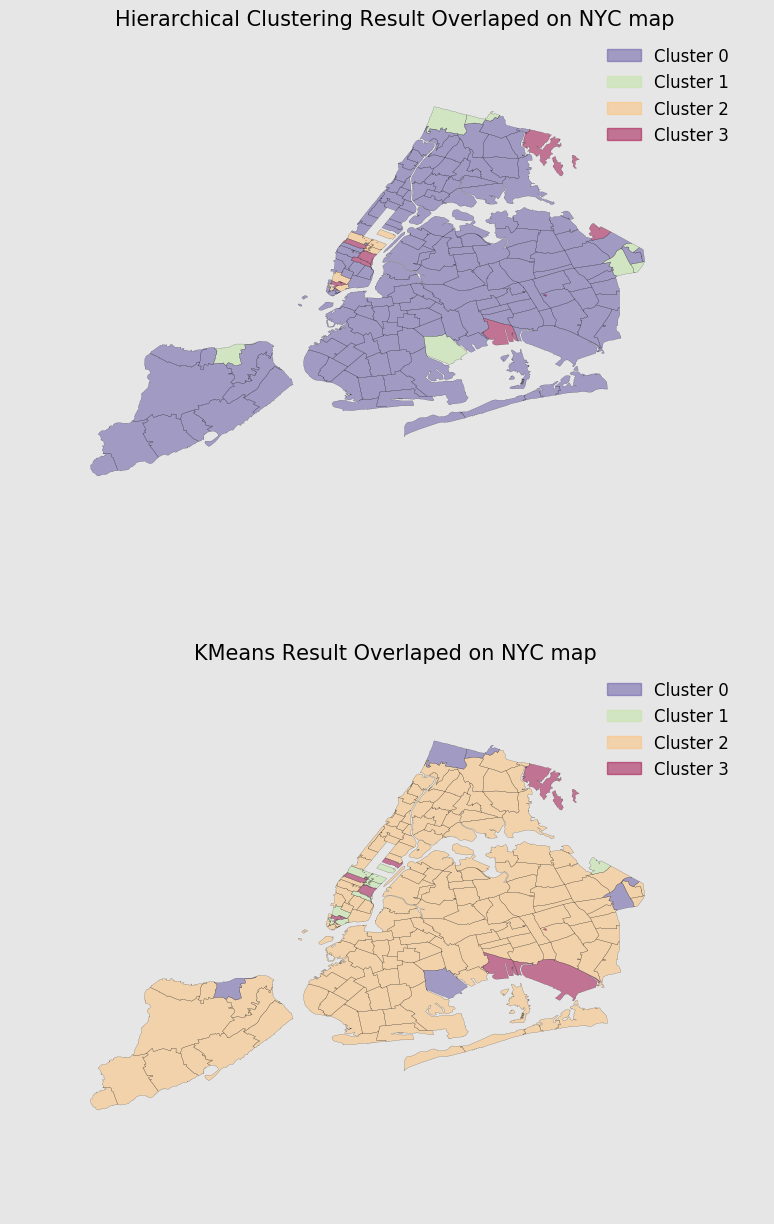

In [113]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(9,15))
HCplot.plot(ax=ax1, column='label', cmap=plt.cm.Spectral, linewidth=0.1, label='_nolegend_')
KMplot.plot(ax=ax2, column='label', cmap=plt.cm.Spectral, linewidth=0.1, label='_nolegend_')
ax2.set_title('KMeans Result Overlaped on NYC map', fontsize=15)
fig.set_facecolor('0.9')
ax1.set_title('Hierarchical Clustering Result Overlaped on NYC map', fontsize=15)
patch = [mpatches.Patch(color=cmap[i], alpha=0.5, label='Cluster %i'%i) for i in range(4)]
ax1.legend(handles=patch, frameon=False)
ax2.legend(handles=patch, frameon=False)
ax1.set_axis_off()
ax2.set_axis_off()